In [1]:
import geopandas
import pandas
import starepandas
import pystare
import shapely
import matplotlib.pyplot as plt

In [2]:
cities = {'name': ['midway', 'Fiji', 'Baker', 'honolulu'],
          'lat': [28.2, -17.8,  0.2, 21.3282956], 
          'lon': [-177.35, 178.1, -176.7, -157.9]}
                   
cities = starepandas.STAREDataFrame(cities)
sids = starepandas.sids_from_xy(cities.lon, cities.lat, resolution=1)
cities.set_sids(sids, inplace=True)
trixels = cities.make_trixels(wrap_lon=False)
cities.set_trixels(trixels, inplace=True)

<AxesSubplot:>

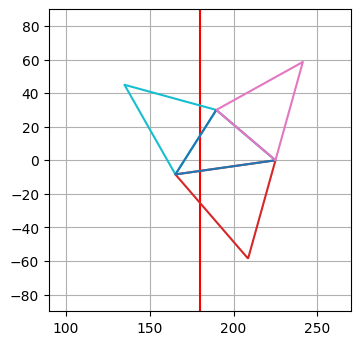

In [3]:
fig, ax = plt.subplots(dpi=100)
ax.grid(True)

antimeridian = shapely.geometry.LineString([(180,-90), (180,90)])

ax.plot(*antimeridian.xy, color='red')
ax.set_ylim(-90,90)
ax.set_xlim(90,270)

cities.plot(ax=ax, column='name')

## Multipolygon

In [17]:
combined = starepandas.STAREDataFrame(sids=[sids, sids])
trixels = combined.make_trixels(wrap_lon=False)
combined.set_trixels(trixels, inplace=True)

# Algorithm

In [18]:
bbox = shapely.geometry.Polygon([(-180, -90), (180, -90), (180, 90), (-180, 90)])

In [19]:
trixels = geopandas.GeoSeries(combined[combined._trixel_column_name])

In [20]:
def split(trixels):
    bbox = shapely.geometry.Polygon([(-180, -90), (180, -90), (180, 90), (-180, 90)])

    trixels = geopandas.GeoSeries(trixels)

    inside = trixels.explode(index_parts=True).reset_index(drop=True)
    inside = inside.intersection(bbox)
    inside = geopandas.tools.collect(inside)

    outside = trixels.explode(index_parts=True).reset_index(drop=True)
    outside = outside.difference(bbox)
    outside = outside.apply(lambda x: shapely.affinity.translate(x, xoff=-360))
    outside = geopandas.tools.collect(outside)

    split = inside.union(outside)
    return split

# Usage

<AxesSubplot:>

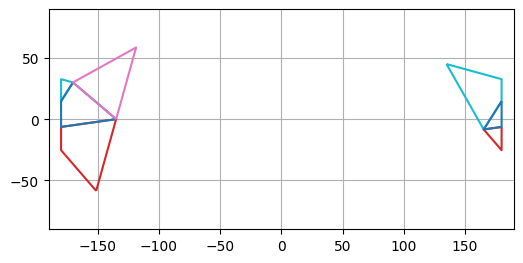

In [21]:
fig, ax = plt.subplots(dpi=100)
ax.grid(True)

ax.set_ylim(-90,90)
ax.set_xlim(-190,190)

cities.split_antimeridian(inplace=True)

cities.plot(ax=ax, column='name')

<AxesSubplot:>

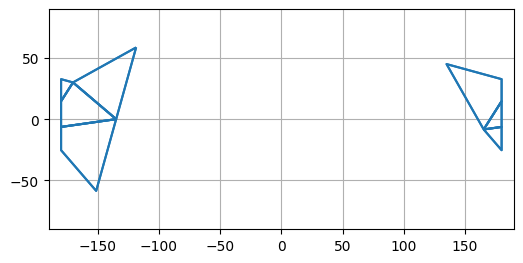

In [22]:
fig, ax = plt.subplots(dpi=100)
ax.grid(True)

ax.set_ylim(-90, 90)
ax.set_xlim(-190, 190)

combined.split_antimeridian(inplace=True)

combined.plot(ax=ax)

In [10]:
cities.trixels[0].geoms[1].exterior.xy

(array('d', [-170.26439000686852, -180.0, -180.0, -170.26439000686852]),
 array('d', [29.999999603043193, 14.653891165651418, 32.667991191813314, 29.999999603043193]))

In [11]:
cities

,name,lat,lon,sids,trixels
0,midway,28.200000,-177.35,871633302546358913,"MULTIPOLYGON (((165.36119 -8.42106, 135.00000 ..."
1,Fiji,-17.800000,178.10,1690257938636846785,"MULTIPOLYGON (((165.36119 -8.42106, 180.00000 ..."
2,Baker,0.200000,-176.70,1217305125799471233,"MULTIPOLYGON (((165.36119 -8.42106, 180.00000 ..."
3,honolulu,21.328296,-157.90,3184891183652070177,"POLYGON ((-118.67505 58.60029, -135.00000 0.00..."
